This notebook provides a simple example of the Bayesian hierarchical modeling that is possible with *phenom*. Three functional replicates are sampled from the model: y = f(x) + r<sub>i</sub>(x) + &epsilon;(x), for some function f and replicate functions r<sub>i</sub>(x). Analysis is then performed with the *phenom* package.

In [1]:
%matplotlib inline

In [2]:
import GPy, scipy
from phenom.design import Formula
from phenom.phenotype import Phenotype
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Below we generate the three functional replicates. As can be seen in the generated figure, the true function f (black) corrupted by replicate curves (colored lines) and the corresponding observations (data points).

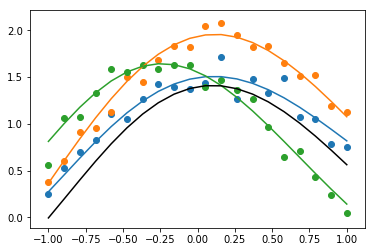

In [34]:
np.random.seed(111)

# number of sample points
n = 20

# number of replicates
r = 3

# construct the sample space
x = np.linspace(-1, 1, n)[:,None]

# kernels for main effect and replicate effect
k1 = GPy.kern.RBF(1)
k2 = GPy.kern.RBF(1, variance=.2)

# sample main and replicate functions
mu = scipy.stats.multivariate_normal.rvs(np.zeros(n), k1.K(x))
b = scipy.stats.multivariate_normal.rvs(np.zeros(n), k2.K(x), size=r)

# build the design matrix
d = np.zeros((r, r+1))
d[:,0] = 1
d[:,1:] = np.eye(r)

# build the mean and sample data
yhat = np.dot(d, np.concatenate((mu[:,None], b.T), 1).T)
y = yhat + scipy.stats.norm.rvs(scale=.1, size=yhat.shape)

plt.plot(x[:,0], yhat.T)
for i in range(r):
    plt.scatter(x, y[i, :])
plt.plot(x, mu, c='k');

Below we use *phenom* to analyze the generated data. A metadata dataframe is constructed describing the replicate number for each curve. A formula describing the mean process (mnull) and complete model with mean and replicate (mfull) is then build. *Phenotype* objects are then created to perform analysis.

In [35]:
# construct metadata and data
meta = pd.DataFrame(np.where(d[:,1:]!=0)[1], columns=['batch'])
data = pd.DataFrame(y.T, index=x[:,0])

# build design matrix
mnull = Formula(meta, '1')
mfull = mnull + Formula(meta, 'C(batch) + 0')

# build phenotypes
mn = Phenotype(data, mnull, maxExpectedCross=4, minExpectedCross=.1)
mf = Phenotype(data, mfull, maxExpectedCross=4, minExpectedCross=.1)

In [28]:
# this generates posterior samples of the different models
# the majority of computation time will be spent here (on model compilation)

nsamples = mn.samples()
fsamples = mf.samples()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b94a1a41f39d75712eac6284f5183d7d NOW.
 /anaconda3/envs/phenom-final/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning:Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/cz/7j2rv40n30z87t2fq2c51vrh001wdz/T/tmpaxwanrl5/stanfit4anon_model_b94a1a41f39d75712eac6284f5183d7d_9079369242104743034.pyx
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b94a1a41f39d75712eac6284f5183d7d NOW.
 /anaconda3/envs/phenom-final/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning:Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/cz/7j2rv40n30z87t2fq2c51vrh001wdz/T/tmp7cpuunm3/stanfit4anon_model_b94a1a41f39d75712eac6284f5183d7d_2056211295420878780.pyx


Below we analyze the results of each model. Both appear to have converged, as represented by the rhat metric. Additionally, in the plot of posterior intervals, we see that the complete model has accurately captured the uncertainty due to replicate variation and the corresponding interval covers the true function.

In [29]:
nsamples

Inference for Stan model: anon_model_b94a1a41f39d75712eac6284f5183d7d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lengthscale[1]   0.45  4.5e-3   0.14   0.22   0.35   0.44   0.53   0.78    986    1.0
alpha[1]          2.0    0.03   0.92   0.76   1.34   1.81   2.47   4.31   1095    1.0
sigma            0.65  9.9e-4   0.06   0.54    0.6   0.64   0.68   0.79   4122    1.0
f_eta[1,1]      -0.83    0.01   0.37  -1.74  -1.02  -0.76  -0.56  -0.32   1080    1.0
f_eta[1,2]        1.4    0.01   0.56   0.35   1.01   1.38   1.76   2.57   2756    1.0
f_eta[1,3]       0.18    0.02    0.8  -1.46  -0.34   0.17   0.69   1.74   2474    1.0
f_eta[1,4]      -0.23    0.02   0.92  -2.06  -0.83  -0.22    0.4   1.56   2645    1.0
f_eta[1,5]      -0.35    0.02   0.93  -2.16  -0.98  -0.35   0.28   1.45   2678    1.0
f_eta[1,6]      -0.41    0.02   0.92 

In [30]:
fsamples


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_b94a1a41f39d75712eac6284f5183d7d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lengthscale[1]   0.57  5.7e-3   0.19   0.28   0.43   0.55   0.67   0.94   1103    1.0
lengthscale[2]   0.57  5.1e-3   0.19   0.32   0.45   0.53   0.64   1.04   1412    1.0
alpha[1]         2.68    0.03   1.15   1.05   1.85   2.48   3.29   5.51   1679    1.0
alpha[2]         0.99  9.7e-3   0.41   0.49   0.72   0.89   1.16   2.05   1782    1.0
sigma            0.21  3.5e-4   0.02   0.17    0.2   0.21   0.23   0.26   4177    1.0
f_eta[1,1]      -0.63  8.8e-3   0.36  -1.49  -0.82  -0.58  -0.39  -0.05   1725    1.0
f_eta[2,1]      -0.53    0.01   0.59  -1.66  -0.93  -0.53  -0.13   0.67   2415    1.0
f_eta[3,1]      -0.33    0.01   0.59  -1.47  -0.73  -0.33   0.07   0.81   2292    1

In [31]:
nsamp = nsamples.extract()
fsamp = fsamples.extract()

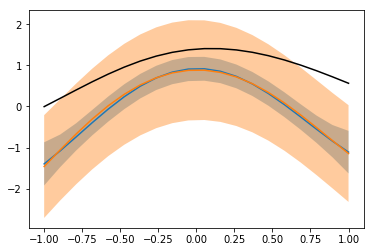

In [32]:
ind = 0
m = nsamp['f'][:,ind,:].mean(0)
s = nsamp['f'][:,ind,:].std(0)

plt.plot(x, m)
plt.fill_between(x[:,0], m-2*s, m+2*s, alpha=.4)

m = fsamp['f'][:,ind,:].mean(0)
s = fsamp['f'][:,ind,:].std(0)

plt.plot(x, m)
plt.fill_between(x[:,0], m-2*s, m+2*s, alpha=.4)

plt.plot(x, mu, c='k')